# Compare InSAR and GNSS LOS velocities

### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy
from scipy.interpolate import RegularGridInterpolator

### Read in the velocity file
You will create this file using the Mintpy or other time-series software library. Some software packages generate an HDF5 or a netcdf file instead of a tif file, so I've written a helper module to convert an HDF5 file (generated by Mintpy) to a tif file that can be read into any GIS software. 

In [2]:
with rasterio.open('velocity.tif', 'r') as f:
    xy = f.xy
    trans = f.transform
    crs = f.crs
    bounds = f.bounds
    vel = f.read(1)

x = np.array([trans[2] + trans[0] * k for k in range(vel.shape[1])])
y = np.array([trans[5] + trans[4] * k for k in range(vel.shape[0])])

In [3]:
print(x.shape)
print(y.shape)
[X, Y] = np.meshgrid(x, y)
print(X.shape)
print(vel.shape)

(3507,)
(2681,)
(2681, 3507)
(2681, 3507)


In [4]:
vel[vel == 0.0] = np.nan

In [5]:
bb = list(bounds)
bb2 = [bb[0], bb[2], bb[1], bb[3]]

### Load GNSS file containing Line-of-sight GNSS velocities
You can create this file using [another notebook](https://github.com/jlmaurer/gemlab/blob/419cd457ab0dd86acdbdea27baea366cb1926644/software/gnss/Load_GPS_UNR.ipynb) available on my `gemlab` Github. 
This file should have a column named "LOS_VEL" and "x" and "y" columns which are in the same coordinate reference frame as the InSAR. The notebook linked above shows you how to create these columns. 

In [6]:
gnss_file_name = 'gnss_file.csv'
df_gnss = pd.read_csv(gnss_file_name)

### Plot both InSAR and GNSS velocities

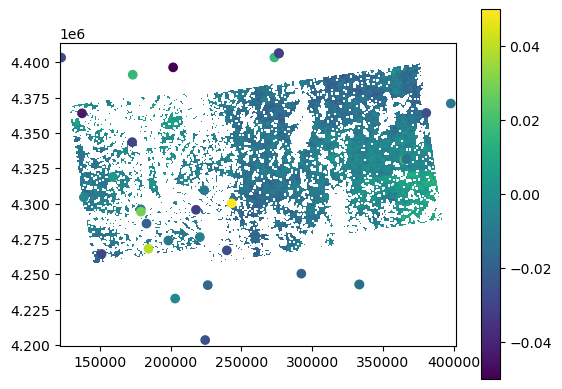

In [7]:
cax = plt.imshow(vel, vmin=-0.05, vmax=0.05, extent=bb2)
plt.scatter(df_gnss['x'], df_gnss['y'], c=df_gnss['LOS_VEL'])
cbar = plt.colorbar(cax)
plt.show()

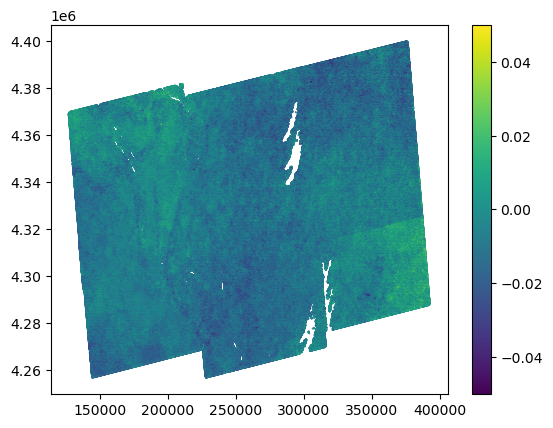

In [9]:
# Same plot, but different plot style allows for seeing more pixels
cax = plt.scatter(X.ravel(), Y.ravel(), c=vel.ravel(), s=1, marker='.', vmin=-0.05, vmax=0.05)
plt.scatter(df_gnss['x'], df_gnss['y'], c=df_gnss['LOS_VEL'])
cbar = plt.colorbar(cax)
plt.show()

### Calculate InSAR - GNSS differences
In this section we will calculate the difference between the InSAR velocities and the GNSS. 
In order to do this we need to interpolate the InSAR velocities in some way to the GNSS locations. 
We will do both regular interpolation and a mean velocity in a window around each GNSS station and compare. 

In [12]:
interp = RegularGridInterpolator((y, x), vel, bounds_error=False)
pts = np.array([df_gnss['y'], df_gnss['x']]).T
vel_Insar = interp(pts)

In [ ]:
# loop through each GNSS station and calculate the mean velocity within a small box around each GNSS station
dxy = 100  # dxy will depend on your coordinate system. This one is in meters
meanV_Insar = []
for k, row in df_gnss.iterrows():
    mask = (x > row['x'] - dxy) & (x < row['x'] + dxy) & (y > row['y'] - dxy) & (y < row['y'] + dxy)
    meanV_Insar.append(np.nanmean(vel[mask]))
meanV_Insar = np.array(meanV_Insar)

In [15]:
# calculate RMSE
rmse_interp = np.sqrt(np.sum(np.square(vel_Insar - df_gnss['LOS_VEL'])))
rmse_bbox = np.sqrt(np.sum(np.square(meanV_Insar - df_gnss['LOS_VEL'])))

print('Original RMSE not accounting for plane correction')
print(f'Using interpolation: {rmse_interp}')
print(f'Using the mean of a small box around each point: {rmse_bbox}')

0.047233441988340244


### Solve for and remove a plane from the InSAR
InSAR is inherently a relative deformation measurement; in other words, displacements are measured relative to one particular pixel within the image. 
In order to put the image into an absolute reference frame, we remove a plane between the InSAR and GNSS at the locations where we have both measurements. Of course, this requires GNSS stations distributed around the extend of the frame. 
In the abscence of well-distributed stations, we can remove a single static shift. 

In [ ]:
gnss_vel = gnss_df['LOS_VEL']
mask = np.isnan(gnss_vel)

# set up the model matrix
G = np.stack([np.ones(len(vel_Insar), 1), gnss_df['x'], gnss_df['y']], axis=-1)

# remove nans
gnss_vel[mask] = []
G[mask, :] = []

# solve for three parameters: two slopes and an intercept
mhat, res, rank, s = np.linalg.lstsq(G, gnss_vel)

# mhat is the estimated parameters for a plane
# We re-create G to correct all the InSAR pixels
G = np.stack([np.ones(len(vel.ravel()), 1), xy[:, 0], xy[:, 1]], axis=-1)
predicted_plane = np.dot(G, mhat)

residual_Insar = vel - predicted_plane

In [ ]:
# Now re-calculate all the residuals
interp = RegularGridInterpolator((y, x), residual_Insar, bounds_error=False)
pts = np.array([df_gnss['y'], df_gnss['x']]).T
vel_Insar = interp(pts)

meanV_Insar = []
for k, row in df_gnss.iterrows():
    mask = (x > row['x'] - dxy) & (x < row['x'] + dxy) & (y > row['y'] - dxy) & (y < row['y'] + dxy)
    meanV_Insar.append(np.nanmean(residual_Insar[mask]))
meanV_Insar = np.array(meanV_Insar)

rmse_interp = np.sqrt(np.sum(np.square(vel_Insar - df_gnss['LOS_VEL'])))
rmse_bbox = np.sqrt(np.sum(np.square(meanV_Insar - df_gnss['LOS_VEL'])))

print('Original RMSE not accounting for plane correction')
print(f'Using interpolation: {rmse_interp}')
print(f'Using the mean of a small box around each point: {rmse_bbox}')

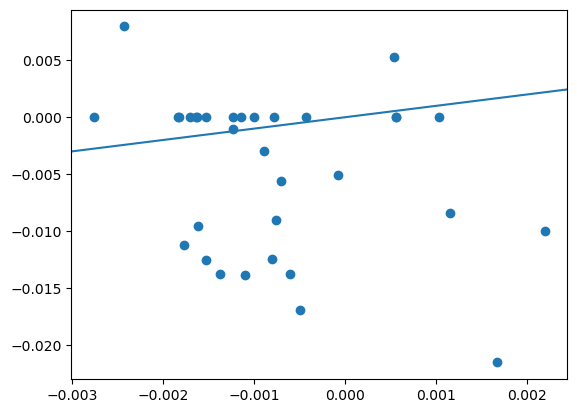

In [16]:
plt.scatter(df_gnss['LOS_VEL'], meanV_Insar)
plt.axline((0, 0), slope=1)
plt.xlabel('GNSS LOS velocity')
plt.ylabel('InSAR LOS velocity')

In [17]:
gnss_self_std = np.std(df_gnss['LOS_VEL'])
insar_self_std = np.std(residual_Insar)
difference_std_interp = np.std(vel_Insar - df_gnss['LOS_VEL'])
difference_std_mean = np.std(meanV_Insar - df_gnss['LOS_VEL'])

0.0011407138013056315

In [31]:
# Calculate R^2
gnss_vel = df_gnss['LOS_VEL'][~np.isnan(df_gnss['LOS_VEL'])]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    meanV_Insar[~np.isnan(df_gnss['LOS_VEL'])], gnss_vel
)

In [32]:
print(r_value**2)

2.0814120948601724e-05
